In [1]:
import numpy as np
import matplotlib.pyplot as plt

# from sklearn.linear_model import LinearRegression
# from sklearn.preprocessing import scale as std_scale, robust_scale

# from scipy.signal import find_peaks, find_peaks_cwt, peak_widths

import numpy as np
# from sklearn.datasets import load_digits
from sklearn.preprocessing import scale
import sklearn.metrics as metrics

import matplotlib.pyplot as plt
import matplotlib.animation as ani

import mlgrad.models as models
import mlgrad.regr as regr
import mlgrad.cls as cls
import mlgrad.plots as plots
import mlgrad.funcs as funcs
import mlgrad.funcs2 as funcs2
import mlgrad.loss as loss
import mlgrad.gd as gd
import mlgrad.smooth as smooth

import rampy
import pybaselines
import random

from irsa import io
from irsa.preprocess import despike, utils


# import xarray as xr

import ipywidgets

# %matplotlib widget

In [2]:
# d = io.load_spectras(f"/home/intellimath/repos/spectras", {"штамм_бактерий": "96"})
d = io.load_spectras(f"/home/intellimath/repos/spectras", 
                     {"отсечки_по_молекулярной_массе": "less30", "начальная_концентрация_клеток_в_пробе": "6"})
# d = io.load_spectras(f"/home/intellimath/repos/spectras", {})

for i, key in enumerate(d):
    entry1 = d[key]
    entry1.crop(42)
    entry1.smooth(tau=10.0)
    entry1.allign_bottom()
    entry1.remove_overflow_spectras(y_max=2000.0, y_max_count=30)
    entry1.remove_outlier_spectras(delta=0.10, tau=3.0)
    # entry1.remove_by_zscore_spectras(tau=3.5, max_count=50)
    print(len(entry1.y))
    

3_1_SA_96_R_6_1_less30_1_0
3_1_SA_92_S_6_1_less30_1_0
3_1_SA_93_S_6_1_less30_1_0
3_2_SA_93_S_6_1_less30_1_!24hours after drying!
3_2_SA_92_S_6_1_less30_1_!24hr_after_drying!
3_2_SA_96_R_6_1_less30_1_!24hours after drying!
60
34
51
32
60
33


In [3]:
d_keys = list(d.keys())
sel_i = 0
sel = ipywidgets.Select(options=d_keys,  description="Key:", rows=len(d)+1)
sel.layout.width="50%"

i_slider = ipywidgets.IntSlider(min=0, max=len(d[d_keys[0]].y)-1)
i_slider.layout.width="50%"

f_slider = ipywidgets.FloatSlider(value=3.5, min=1.0, max=10.0)
f_slider.layout.width="50%"

def sel_on_value_change(change):
    i_slider.value = 0
    i_slider.max = len(d[sel.value].y)-1

# def i_on_value_change(change):
#     plot_spectra_series(sel.value, i_slider.value, f_slider.value)

# def f_on_value_change(change):
#     plot_spectra_series(sel.value, i_slider.value, f_slider.value)

sel.on_trait_change(sel_on_value_change, name="value")
# i_slider.on_trait_change(i_on_value_change, name="value")
# f_slider.on_trait_change(f_on_value_change, name="value")

# ipywidgets.VBox([sel, i_slider, out])

In [4]:
def plot_spectra_series(key, i, zval):
    plt.figure(figsize=(12,4))
    entry = d[key]
    x = entry.x[i]
    ys = entry.y[i]
    plt.title(f"{key} [{len(entry.y)}] [{len(ys)}]")
    for j, y in enumerate(ys):
        plt.plot(x, y, linewidth=0.5, label=str(j), alpha=0.5)
    ys_m = utils.robust_mean2(ys, tau=zval)
    plt.plot(x, ys_m, linewidth=1.0, color='k')

    dys_m = abs(ys - ys_m) / (ys_m + 0.001)
    dy_m = np.nanmedian(dys_m, axis=0)
    ds = np.nanmedian(dy_m) 
    ds2 = np.nanpercentile(dy_m, 75)
    
    plt.hlines(0, 0, max(x), colors='k', linestyles='--')
    plt.xlim(-10, max(x)+10)
        
    plt.minorticks_on()
    plt.tight_layout()
    plt.legend([str(i), f"{ds:.2f} / {ds2:.2f}"])
    plt.show()

def plot_zscore_series(key, i, zval):
    plt.figure(figsize=(12,2))
    # plt.title(f"Modified z-score: {key}: {i}")
    entry = d[key]
    x = entry.x[i]
    ys = entry.y[i]
    zs = utils.modified_zscore2(ys)
    abs_zs = abs(zs)
    for z in abs_zs:
        plt.plot(x, z, linewidth=0.5, alpha=0.5)
    plt.plot(x, utils.robust_mean2(abs_zs, tau=zval), linewidth=2.0, color='k')
    plt.hlines(0, 0, max(x), colors='k', linestyles='--')
    plt.hlines(zval, 0, max(x), colors='k', linewidth=1.0)
    plt.xlim(-10, max(x)+10)
    plt.ylim(0, 7)
        
    plt.minorticks_on()
    plt.tight_layout()
    plt.legend(["Modified z-score"])
    plt.xticks([])
    plt.show()

@ipywidgets.interact(key=sel, i=i_slider, f=f_slider, zscore=False)
def plot_spectra_zscore(key, i, f, zscore):
    if i > len(d[key].y)-1:
        i = 0
        i_slider.value=i
        i_slider.max = len(d[key].y)-1

    plot_spectra_series(key, i, f)
    if zscore:
        plot_zscore_series(key, i, f)


interactive(children=(Select(description='Key:', layout=Layout(width='50%'), options=('SA_92_S_less30_6_202407…

In [5]:
d2 = {}
for i, key in enumerate(d):
    entry2 = d[key]
    d2[key] = entry2.robust_averaging(tau=3.0)


In [6]:
for i, key in enumerate(d):
    entry3 = d2[key]
    entry3.smooth(methos="irsa", tau=10.0)
    entry3.allign_bottom()
    entry3.normalize_area_under_curve()
    entry3.remove_by_zscore_spectras(tau=5.0, max_count=50)
    entry3.subtract_baseline("aspls", pad=10, lam=1.0e6)
    # entry3.normalize_area_under_curve()
    print(entry3.x.shape, entry3.y.shape)
    # entry3.y = entry3.remove_outlier_spectras(tau=3.5)
    # Is = [i for i,ys in enumerate(entry3.y) if np.any(np.isnan(ys))]
    # print(Is)            

    # # entry3.subtract_baseline("mor", max_half_window=5, min_half_window=1)


(60, 982) (60, 982)
(34, 982) (34, 982)
(51, 982) (51, 982)
(32, 982) (32, 982)
(60, 982) (60, 982)
(33, 982) (33, 982)


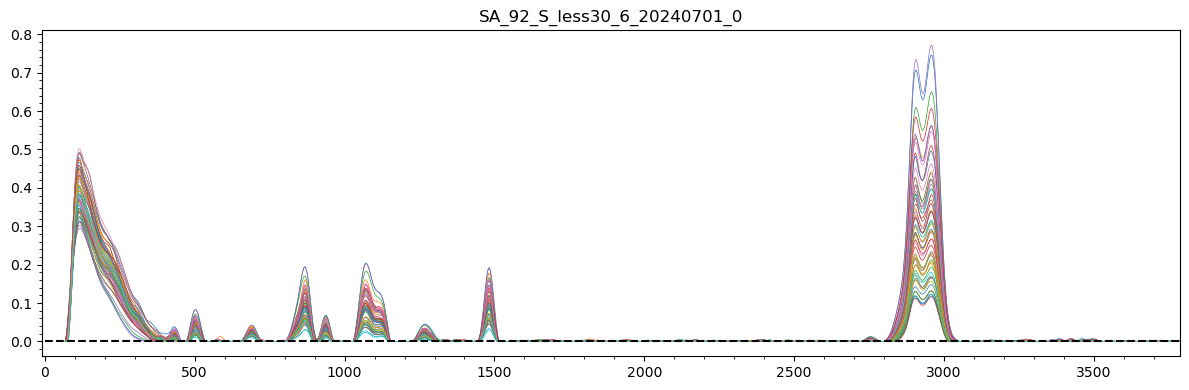

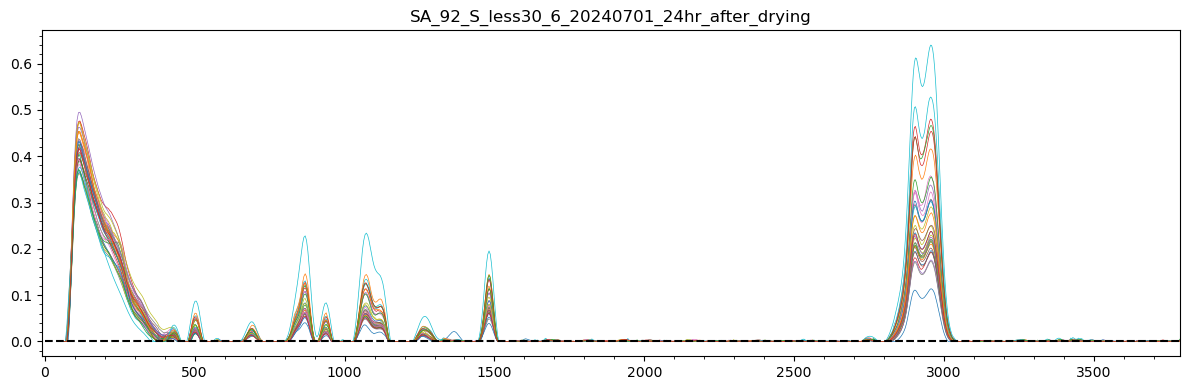

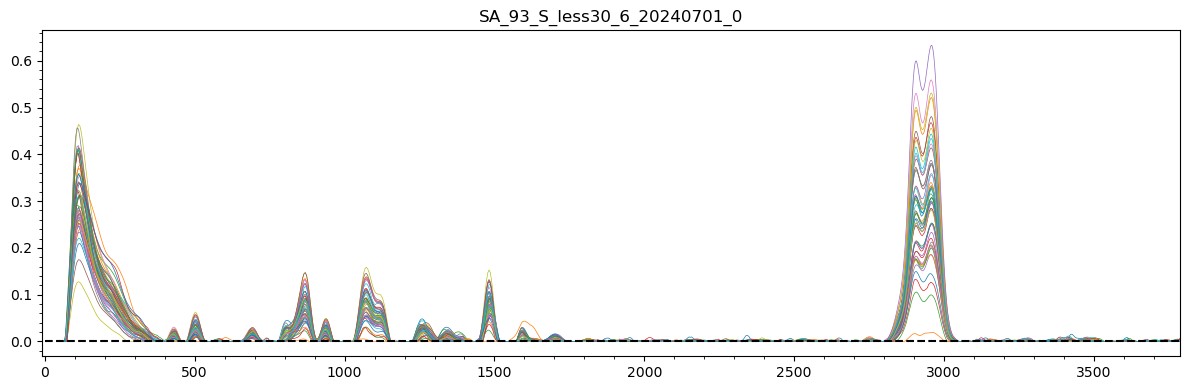

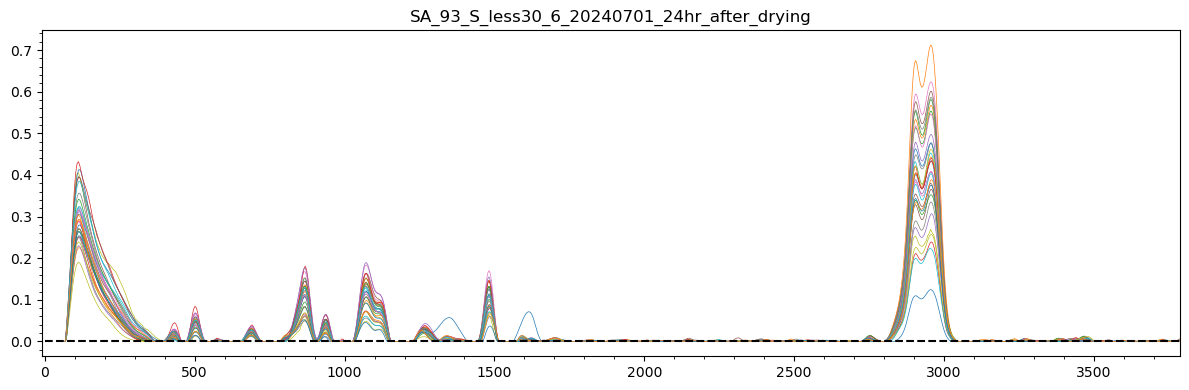

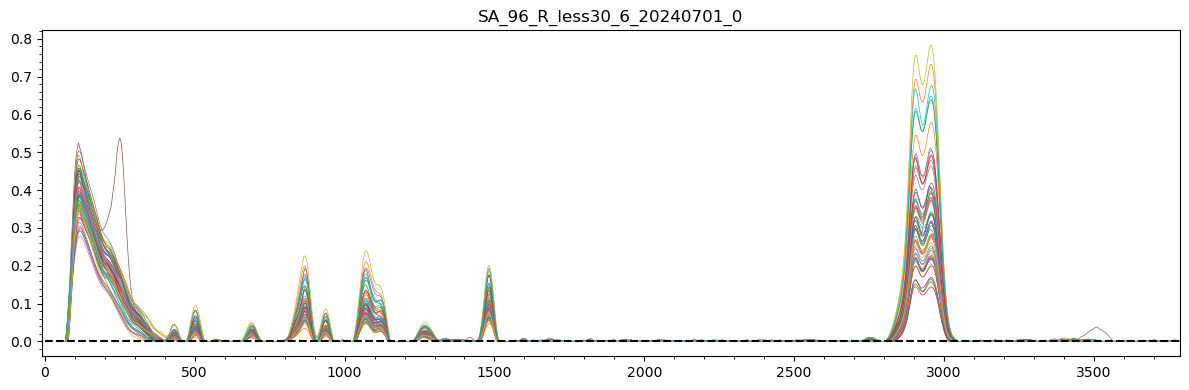

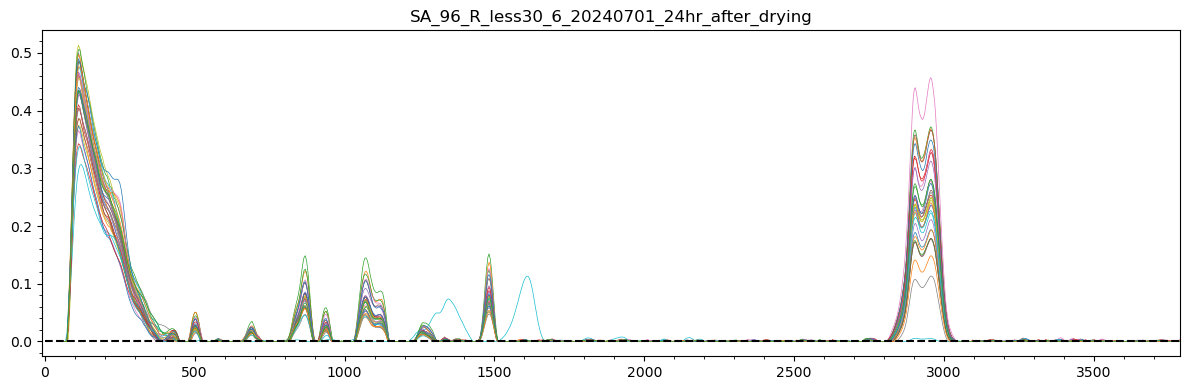

In [7]:
for i, key in enumerate(d):
    entry = d2[key]
    Xs, Ys = entry.x, entry.y

    plt.figure(figsize=(12,4))
    plt.title(key)
    for xs, ys in zip(Xs, Ys):
        plt.plot(xs, ys, linewidth=0.5)
    plt.hlines(0, 0, max(xs), colors='k', linestyles='--')
    plt.xlim(-10, max(xs))
        
    plt.minorticks_on()
    plt.tight_layout()
    # plt.legend()
    plt.show()
    
    # plt.figure(figsize=(12,3))
    # Zs = utils.modified_zscore2(Ys)
    # for xs,zs in zip(Xs,Zs):
    #     plt.plot(xs,abs(zs), linewidth=0.5)
    # plt.minorticks_on()
    # plt.tight_layout()
    # plt.show()
    

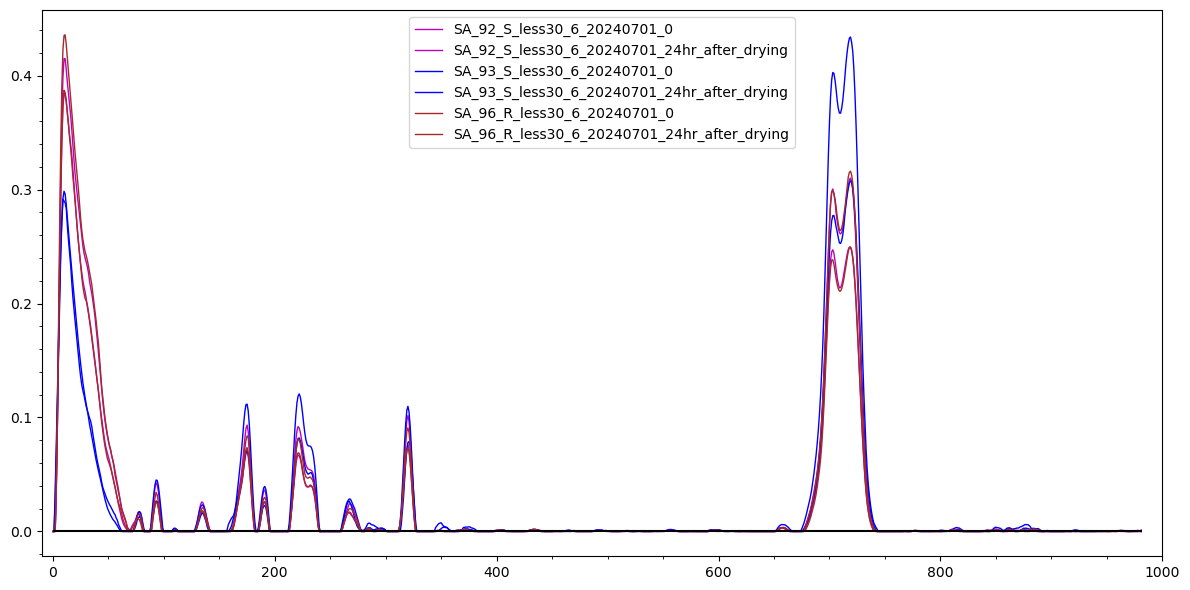

In [8]:
plt.figure(figsize=(12,6))
for i, key in enumerate(d):
    entry = d2[key]
    Xs, Ys = entry.x, entry.y

    if "_R_" in key:
        if "95" in key:
            color='r'
        elif "96" in key:
            color='Brown'
    elif "_S_" in key:
        if "92" in key:
            color='m'
        elif "93" in key:
            color='b'
        else:
            color='b'

    plt.plot(np.median(Ys, axis=0), linewidth=1.0, color=color, label=key)
    
plt.hlines(0, 0, len(Ys[0]), colors='k')
plt.xlim(-10,1000)
        
plt.minorticks_on()
plt.tight_layout()
plt.legend()
plt.show()